# Predicting Outcomes, Party Affiliation

This notebook will develop two predictive models. The first predicts the `outcome` of the roll call vote with the minimum number of senators possible. The second predicts party affilliation with the minimum number of examples. 

#### First,
we will to predict the outcome of a roll call vote ** using a minimal subset ** of the senators' voting records. The reason for this may seem unintuitive at first. Granted, when it comes to voting in the Senate, it is public information how each senator votes. We can determine the outcome with 100% accuracy by simple inspection. We don't need a model to predict the outcome of roll call votes after they have occured. So, *why* would we make this kind of model? 

Recall that we developed a mathematical measure of influence based on mutual information (Kullback - Leibler Divergence) that allows us to rank an individual senator by how influential her individual votes were on the final outcome. We know that we can perfectly predict the outcome of a vote with information about how all senators vote, but what if we only consider a small subset of senators? Questions we want to answer are:

  - What is the minimum number of senators needed to predict the outcome of vote?
  - Is there a number `n < 100` of influential senators' voting records, when taken together, totally predictive of the outcome? 
  - Which senators should we include? 
  
  
#### Second,
we want to predict an individual senator's party affiliation. Similar to the above, this problem is easily sovled by simple inspection. So, why make a model? Our motivataions are similar to the above:

   - Is there a minimum number  `n < 100` of example senators' records which, when used in training, will allow for 100% prediction accuracy for the party of an unseen senator's voting record?
   - Which individual issues (the issues are our features -- e.g. Senate Resolution 11) are most predictive of party affiliation? 
  


The influence score we developed is designed to help answer these questions.

In [71]:
# read in the Series of senators by influence score
from sklearn.externals import joblib
import numpy as np


senators_by_score = joblib.load('../data/senators_by_influence.pkl')
print (senators_by_score[:10])

Cochran (R-MS)      0.165132
McConnell (R-KY)    0.163380
Alexander (R-TN)    0.155987
Hatch (R-UT)        0.146168
Capito (R-WV)       0.140117
Rounds (R-SD)       0.127858
Ayotte (R-NH)       0.114744
Isakson (R-GA)      0.105607
Cornyn (R-TX)       0.105307
Burr (R-NC)         0.105040
dtype: float64


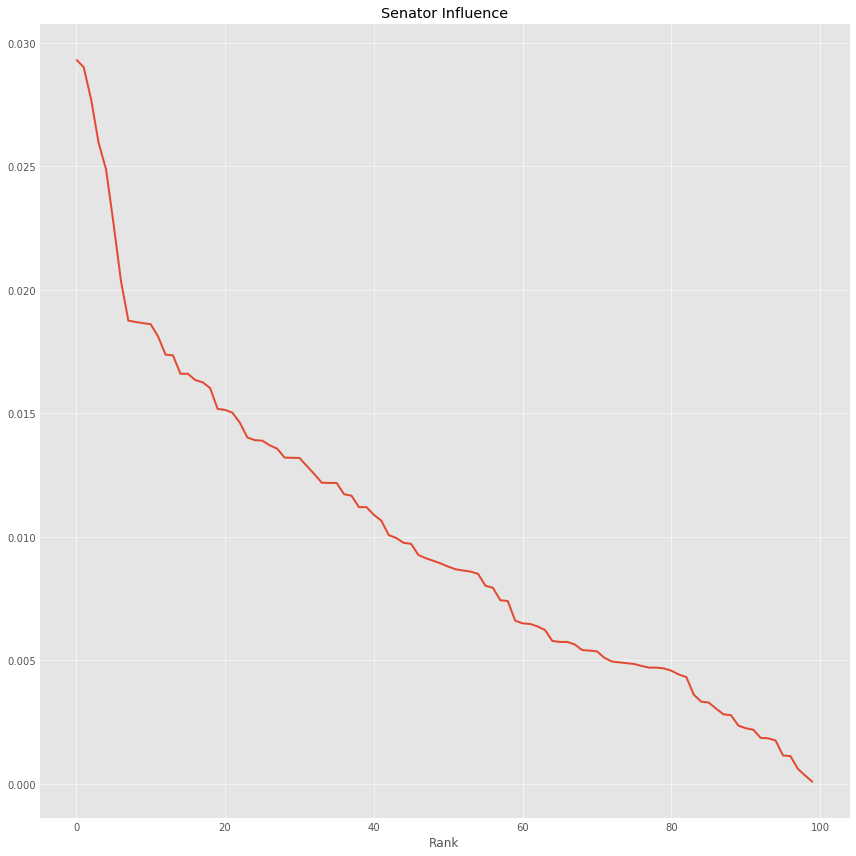

In [506]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 12)

# examining influence
plt.plot((senators_by_score.values) / senators_by_score.values.sum())
plt.title('Senator Influence')
plt.xlabel('Rank')
plt.tight_layout()
plt.savefig('../gallery/influence_rank.png')

plt.show()

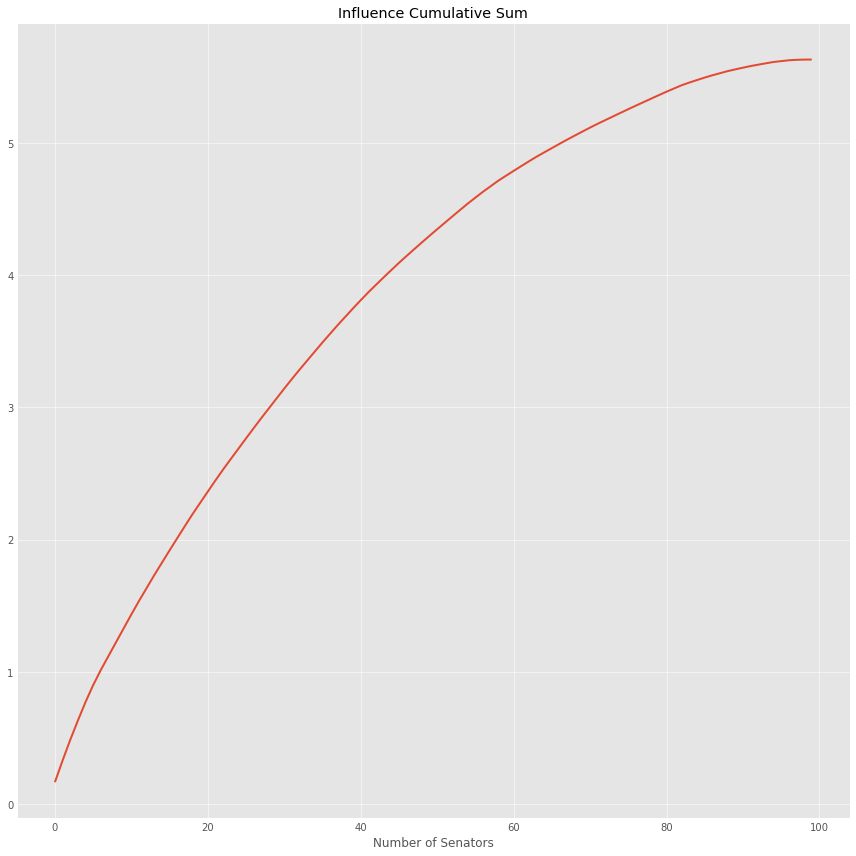

In [507]:
plt.plot(senators_by_score.values.cumsum())
plt.title('Influence Cumulative Sum')
plt.xlabel('Number of Senators')
plt.tight_layout()
plt.savefig('../gallery/influence_cumsum.png')

plt.show()

In [1]:
import pandas as pd
votes = pd.read_csv('../data/cleaned_votes.csv', index_col=0)

In [2]:
votes.sample(3)

,Alexander (R-TN),Ayotte (R-NH),Baldwin (D-WI),Barrasso (R-WY),Bennet (D-CO),Blumenthal (D-CT),Blunt (R-MO),Booker (D-NJ),Boozman (R-AR),Boxer (D-CA),...,Tillis (R-NC),Toomey (R-PA),Udall (D-NM),Vitter (R-LA),Warner (D-VA),Warren (D-MA),Whitehouse (D-RI),Wicker (R-MS),Wyden (D-OR),outcome
461,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,1,1,0,1,0
321,0,0,1,0,1,1,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
30,1,1,0,1,1,0,1,0,1,0,...,1,1,0,1,0,0,0,1,0,0


We are going to test the influence score a few ways. First by iteratively adding in the most infleuntial senators' records to the model. Then we will consider the prediction accuracy using this subset. 

In [428]:
# import libs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [422]:
# choose features and target
target = votes.outcome.values
X = votes.iloc[:, :-1].values

### Baseline

In [430]:
xtrain, xtest,ytrain, ytest = train_test_split(X, target, test_size=.1, random_state=42)

In [526]:
# fit the model
lr  = LogisticRegression(penalty='l1', n_jobs=-1, fit_intercept=True, random_state=3)
lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [527]:
# test the model
lr.score(xtest, ytest)

0.88636363636363635

In [528]:
preds = lr.predict(xtest)
print (classification_report(preds, ytest))

             precision    recall  f1-score   support

          0       0.94      0.79      0.86        19
          1       0.86      0.96      0.91        25

avg / total       0.89      0.89      0.88        44



## Graphing Information Gain

In [529]:
# create a test set and a holdout set ourselves
train_data = votes.sample(300)
train_features = train_data.iloc[:, :-1]
train_target = train_data['outcome']

#get index values to remove from test data
train_indexes  = train_data.index.values
non_dex = votes.index.isin(train_indexes)

#remove train_indexes and create test set
test_data = votes[~non_dex]
test_features = train_data.iloc[:, :-1]
test_target = train_data['outcome']


In [530]:
scores = []
for i in range(1,100):
    senators_list = senators_by_score[:i].index.values
    X_train = train_features[senators_list].values
    X_test = test_features[senators_list].values
    lr.fit(X_train, train_target)
    score = lr.score(X_test, test_target)
    scores.append(score)
scores = np.array(scores)
    
normalized_scores = scores / max(scores)

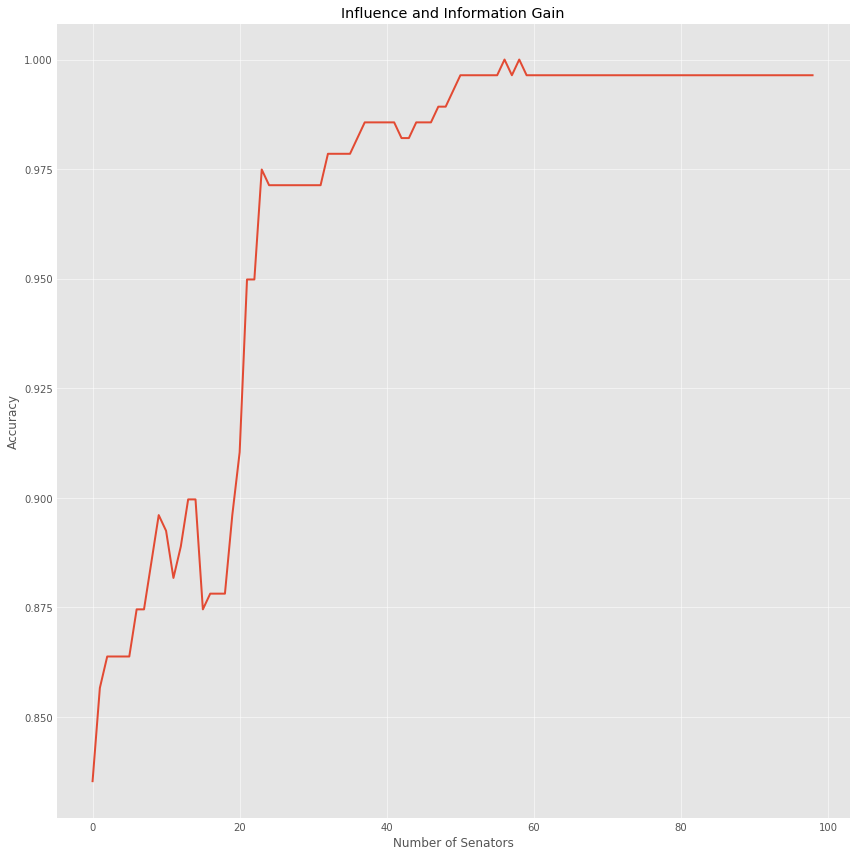

In [531]:
plt.plot(normalized_scores)
plt.title('Influence and Information Gain')
plt.xlabel('Number of Senators')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('../gallery/information_gain_senator_4.png')
plt.show()